In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util.TrainRoutine import AutoEncTrainRoutine
from util.Evaluator import Evaluator
from util.aedpmerf import AEDPMERF

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to use the DPMERF algorithm on time series data. But we will not work on time series directly, because it does not model the temporal relation correctly. Instead we will train an AE first and use DPMERF on the encoding space, where there is no notion of time and ordering.

In [2]:
emb_dim = 32
poll = 2
aedpmerf = AEDPMERF(is_priv=True)

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [3]:
model_name = f"poll{poll}_lstmae_180_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    aedpmerf.load_ae(model_name)
else:
    model, history = aedpmerf.train_ae()
    plt.plot(history["train"])
    plt.plot(history["val"])
    aedpmerf.save_ae(model_name)

loading AE model from models/poll2_lstmae_180_embed32.pth


In [4]:
eps = 0.01
lr = 9e-4
n_epochs = 2000
enc_df = aedpmerf.encode_train_data(train_ds_path=f"data/poll{poll}_normal_train_180.csv", fname=f"data/poll{poll}_normal_training_encoded_embed{emb_dim}_eps{eps}.csv")
aedpmerf.train_gen(data=enc_df, mini_batch_size=0.1, lr=lr, eps=eps, n_epochs=n_epochs)
n_gen_samples = enc_df.shape[0]
gen_data = aedpmerf.generate(n_gen_samples, fname=f"poll{poll}_enc_gen_priv_embed{emb_dim}_eps{eps}.csv")

saving encoded training data in data/poll2_normal_training_encoded_embed32_eps0.01.csv
minibatch:  6983
total number of datapoints in the training data is 69818
random freq (1000, 32)
adding DP noise
Starting Training
epoch # and running loss are  [0, 8.002577662467957]
epoch # and running loss are  [100, 2.83768630027771]
epoch # and running loss are  [200, 2.8059190213680267]
epoch # and running loss are  [300, 2.785391092300415]
epoch # and running loss are  [400, 2.7692036032676697]
epoch # and running loss are  [500, 2.75737527012825]
epoch # and running loss are  [600, 2.7487802505493164]
epoch # and running loss are  [700, 2.7395536601543427]
epoch # and running loss are  [800, 2.7332408726215363]
epoch # and running loss are  [900, 2.731279671192169]
epoch # and running loss are  [1000, 2.724964290857315]
epoch # and running loss are  [1100, 2.72679540514946]
epoch # and running loss are  [1200, 2.720912665128708]
epoch # and running loss are  [1300, 2.7188048660755157]
epoch #

In [5]:
pd.DataFrame(gen_data).to_csv(f"data/generated/poll{poll}_normal_train_180_embed{emb_dim}_priv001_merf.csv")

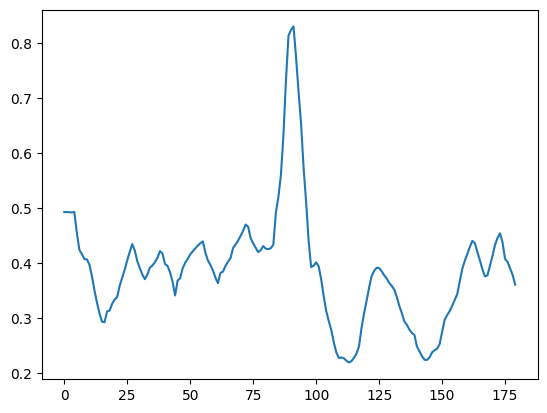

In [6]:
plt.plot(gen_data[345])

In [7]:
ae_gen = AutoEncTrainRoutine()

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


loss: 112.430702  [    1/69828]
loss: 3.448244  [10001/69828]
loss: 16.722532  [20001/69828]
loss: 11.061797  [30001/69828]
loss: 9.342663  [40001/69828]
loss: 2.300452  [50001/69828]
loss: 10.387639  [60001/69828]
Epoch 1: train loss = 7.4807005810768, val loss = 8.760660669269628
loss: 10.943440  [    1/69828]
loss: 0.907527  [10001/69828]
loss: 0.847104  [20001/69828]
loss: 0.968515  [30001/69828]
loss: 0.938995  [40001/69828]
loss: 0.351542  [50001/69828]
loss: 2.471561  [60001/69828]
Epoch 2: train loss = 2.7925280248465123, val loss = 9.109128047948333
loss: 0.314254  [    1/69828]
loss: 0.581353  [10001/69828]
loss: 6.255202  [20001/69828]
loss: 0.851117  [30001/69828]
loss: 1.391879  [40001/69828]
loss: 0.379629  [50001/69828]
loss: 1.676243  [60001/69828]
Epoch 3: train loss = 2.2691159151405302, val loss = 8.709764221463367
loss: 0.936608  [    1/69828]
loss: 3.864877  [10001/69828]
loss: 0.286759  [20001/69828]
loss: 0.278837  [30001/69828]
loss: 0.311104  [40001/69828]
loss

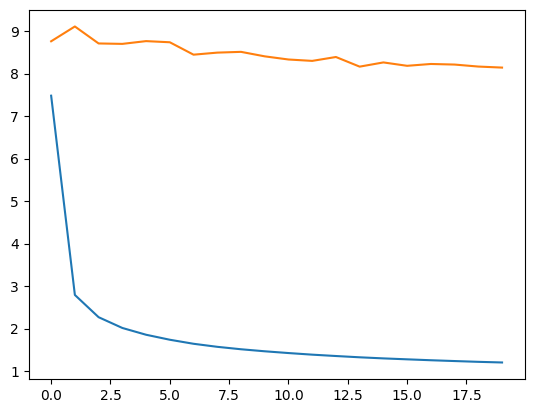

In [8]:
model_name = f"poll{poll}_dpmerf_priv001_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    ae_gen.load_model(model_name)
else:
    model, history = ae_gen.train_model(train_ds_path=f"data/generated/poll{poll}_normal_train_180_embed{emb_dim}_priv001_merf.csv", val_ds_path=f"data/poll{poll}_normal_val_180.csv")
    plt.plot(history["train"])
    plt.plot(history["val"])
    ae_gen.save_model(model_name)

In [9]:
pd.DataFrame(history["train"]).to_csv(f"loss_history/poll{poll}_priv001_merf_train.csv")
pd.DataFrame(history["val"]).to_csv(f"loss_history/poll{poll}_priv001_merf_val.csv")

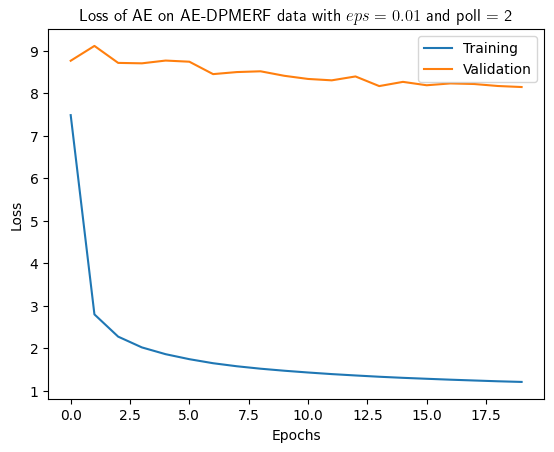

In [10]:
plt.plot(history["train"])
plt.plot(history["val"])
plt.title(f'Loss of AE on AE-DPMERF data with $ eps={eps} $ and poll = {poll}', usetex=True)
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
window_size=180
evaluator = Evaluator(val_normal_path=f"data/poll{poll}_normal_val_{window_size}.csv",
                      val_anomaly_path=f"data/poll{poll}_anomalie_val_{window_size}.csv",
                        test_normal_path=f"data/normal_test{window_size}.csv",
                        test_anomaly_path=f"data/anomalie_test{window_size}.csv", 
                        model=ae_gen.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


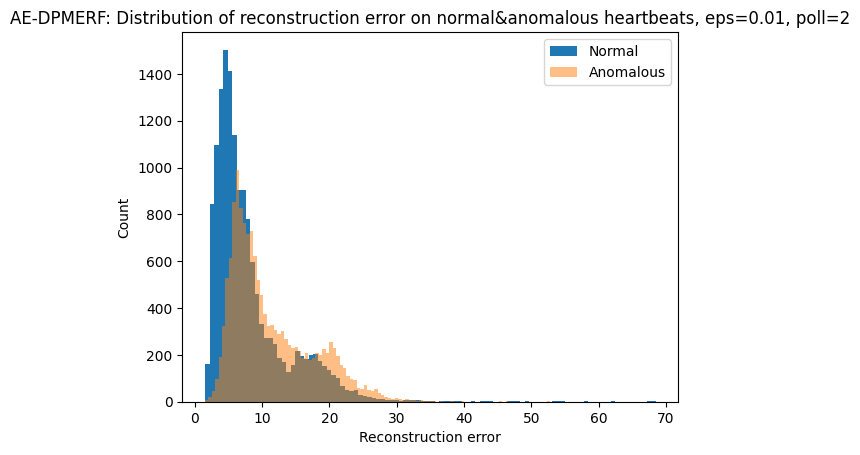

In [12]:
plt.figure()

plt.hist(evaluator.loss_val_normal, bins=100)

plt.title(f"AE-DPMERF: Distribution of reconstruction error on normal&anomalous heartbeats, eps={eps}, poll={poll}")

plt.hist(evaluator.loss_val_anomaly, bins=100, alpha=0.5)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")

plt.legend(["Normal", "Anomalous"])

plt.show()

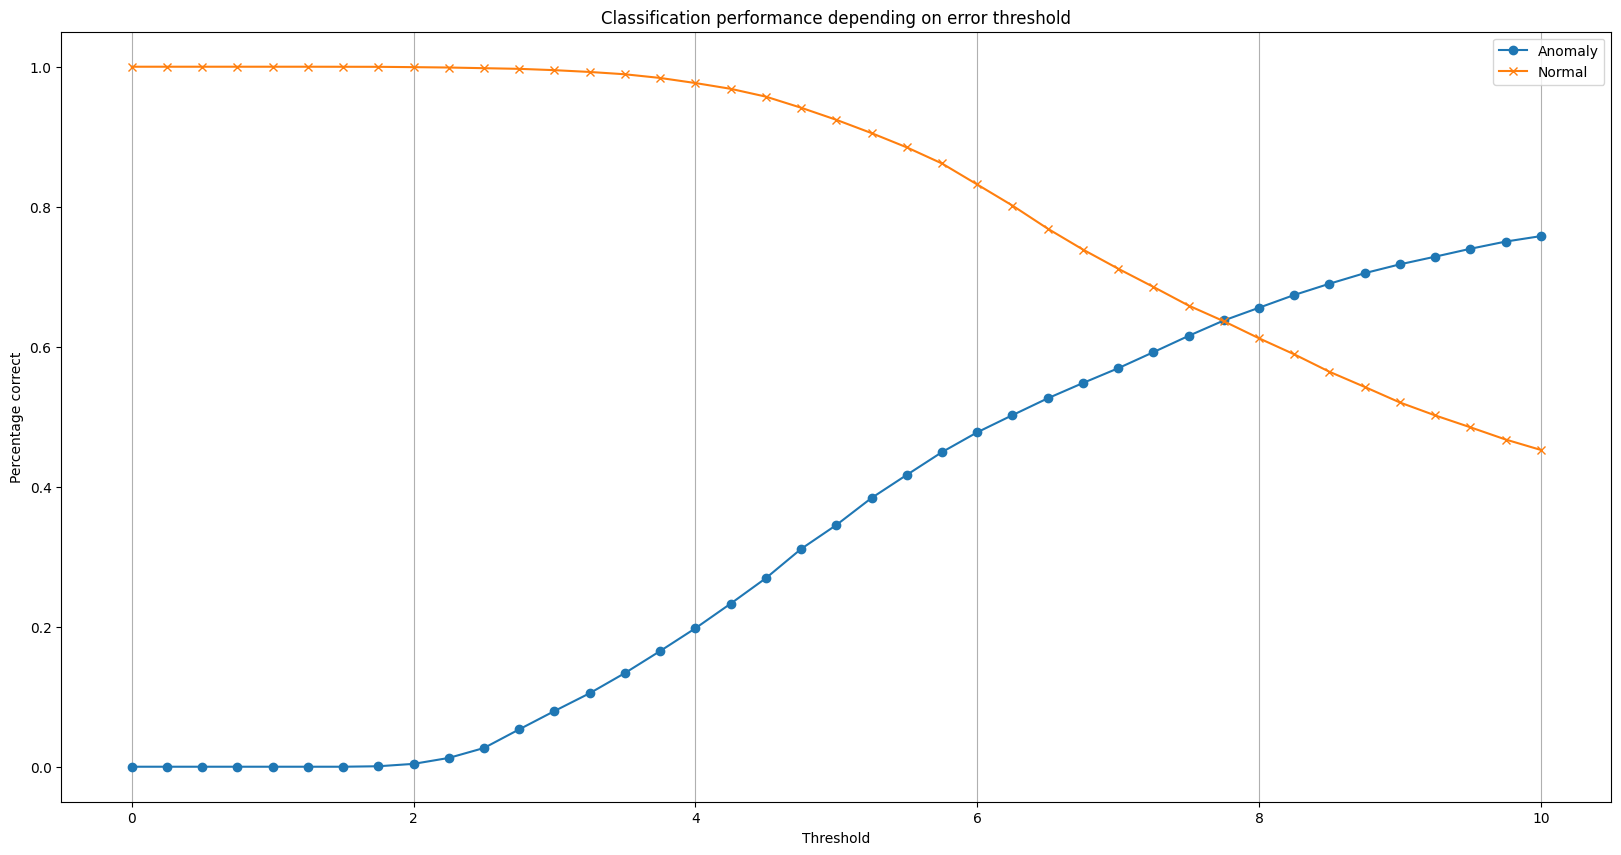

In [16]:
corr_normal, corr_anomaly = evaluator.find_threshold(np.linspace(0,10,41))
plt.figure(figsize=(20,10))
plt.plot(np.linspace(0,10,41), corr_normal, marker="o")
plt.plot(np.linspace(0,10,41), corr_anomaly, marker="x")
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.legend(["Anomaly", "Normal"])
plt.grid(axis="x")
plt.title("Classification performance depending on error threshold")
plt.show()

In [17]:
predictions_normal, predictions_anomaly = evaluator.predict_class(7.75)


/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [18]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

TP: 1125
FN: 635
FP: 682
TN: 1122
Acc: 0.6304713804713805
Precision: 0.6225788599889319
Recall: 0.6392045454545454
F1: 0.6307821698906644
